<a href="https://colab.research.google.com/github/tago893/capstone/blob/main/models/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ethereum Predictions with ARIMA

## Contents:
* [Monthly Forecasting](#monthlyForecasting)
    * [Stationarity check and Seasonal decomposition](#StationarityCheck)
    * [Transformation](#Transformation)
    * [Differencing](#Differencing)
        * [Seasonal differentiation](#SeasonalDifferentiation")
        * [Regular differentiation](#RegularDifferentiation")
    * [Autocorrelation](#Autocorrelation")
    * [ARIMAModel](#ARIMAModel")
        * [Analysis of Results](#AnalysisARIMA")
        * [PredictionARIMA](#PredictionARIMA")

In [101]:
!pip install pandas-datareader
!pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats

In [103]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

In [104]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() 

# download dataframe
data = pdr.get_data_yahoo("ETH-USD")

[*********************100%***********************]  1 of 1 completed


In [105]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...
2023-02-27,1640.763672,1662.575684,1615.387939,1634.326416,1634.326416,7239824677
2023-02-28,1634.502441,1644.435791,1602.428101,1605.895142,1605.895142,6323676957
2023-03-01,1606.040405,1663.433716,1601.548584,1663.433716,1663.433716,7701847224


In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1941 entries, 2017-11-09 to 2023-03-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1941 non-null   float64
 1   High       1941 non-null   float64
 2   Low        1941 non-null   float64
 3   Close      1941 non-null   float64
 4   Adj Close  1941 non-null   float64
 5   Volume     1941 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 106.1 KB


In [107]:
data.dropna(inplace=True)
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Visualization


In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

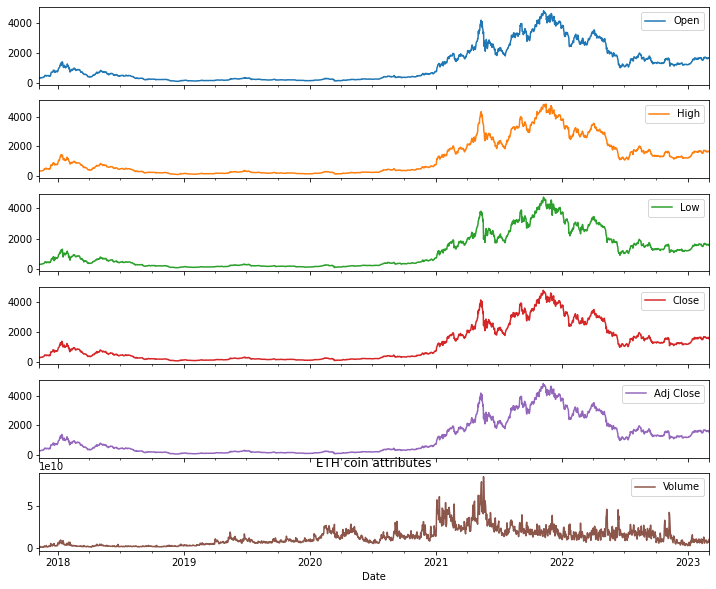

In [109]:
selected_columns = ['Open', 'High', 'Low', 'Close','Adj Close','Volume']
data[selected_columns].plot(subplots=True, figsize=(12,10))
plt.title('ETH coin attributes')
plt.show()

In [110]:
df2=pdr.get_data_yahoo("ETH-USD",)
del df2["Adj Close"]


[*********************100%***********************]  1 of 1 completed


In [111]:
df2.describe()

,Open,High,Low,Close,Volume
count,1941.000000,1941.000000,1941.000000,1941.000000,1.941000e+03
mean,1142.772668,1178.908664,1101.948288,1143.187368,1.273153e+10
std,1171.934663,1207.534747,1130.797279,1171.352313,1.066416e+10
min,84.279694,85.342743,82.829887,84.308296,6.217330e+08
25%,214.230087,220.236389,208.692368,214.219101,4.551740e+09
50%,559.679199,579.372498,537.811646,561.731995,1.031204e+10
75%,1716.405640,1759.884033,1672.612793,1716.494629,1.798094e+10
max,4810.071289,4891.704590,4718.039062,4812.087402,8.448291e+10


# Monthly Forecasting <a name="monthlyForecasting"></a>

This plot helps us visualize the max and min values of monthly helping us
infering that:

1. 30th november 2021 has the high maximum price and 31st december 2018 has high minimum price compared to other years
2. From year 2019 to 2020 the maximum and minimum closing prices of Ethereum closing price are near.

In [112]:
df2_month=df2.resample(rule="MS").mean()

In [113]:
df2_month

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-01,373.696317,393.111908,363.283635,379.732093,1.225341e+09
2017-12-01,630.583997,667.252580,596.163133,640.209291,2.576202e+09
2018-01-01,1093.099893,1163.799714,1024.934606,1103.646004,5.277749e+09
2018-02-01,882.527006,917.850394,825.723679,873.116318,2.978337e+09
2018-03-01,640.787129,653.875259,606.506935,625.761325,1.732780e+09
...,...,...,...,...,...
2022-11-01,1307.122107,1341.226990,1262.868237,1297.930184,1.405993e+10
2022-12-01,1240.294394,1255.038866,1221.342147,1237.105890,5.197763e+09
2023-01-01,1454.913763,1486.601736,1434.767791,1466.950026,7.256547e+09


<AxesSubplot:xlabel='Date'>

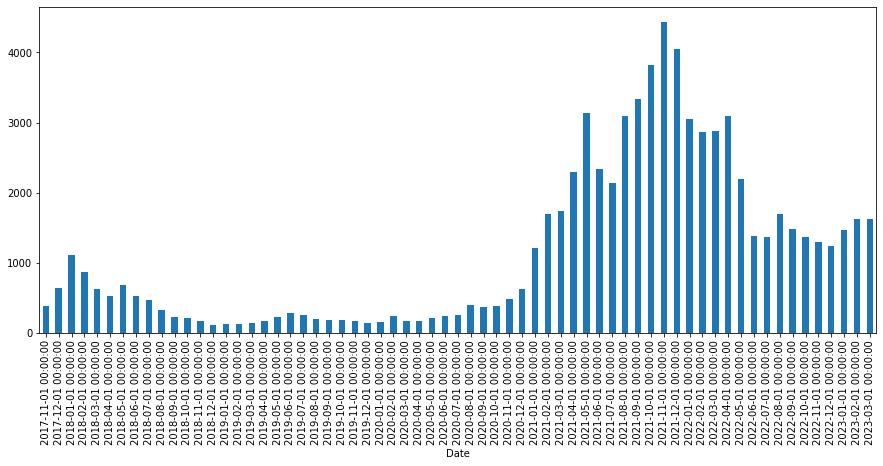

In [114]:
df2['Close'].resample(rule='MS').mean().plot(kind="bar",figsize=(15,6))

# Stationarity check and seasonal decomposition<a name="StationarityCheck"></a>

##Stationarity check

If a time series is stationary, it implies the lack of broad trends (changes in mean and variance over time) in the data. This is important as a consideration in time series forecasting.

In [115]:
import statsmodels.api as sm

<Figure size 2160x720 with 0 Axes>

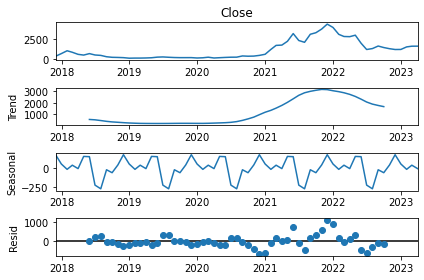

In [116]:
plt.figure(figsize=[30,10])
sm.tsa.seasonal_decompose(df2.resample(rule='M').median().Close).plot()
plt.show()

In [117]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adf_test(data['Close'])

ADF Statistics: -1.4166673528524873
p- value: 0.5742600123437089
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


## Seasonal decomposition

Dickey–Fuller test: p=0.574260


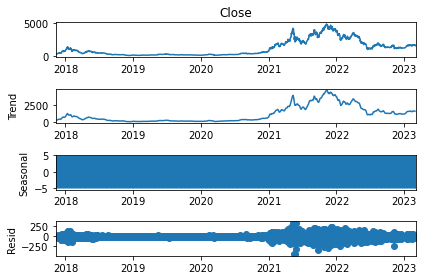

In [118]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(df2.Close).plot()
print("Dickey–Fuller test: p=%f" % adfuller(data.Close)[1])
plt.show()

In [119]:
df2_month = df2.resample('M').mean()
df2_month

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-30,373.696317,393.111908,363.283635,379.732093,1.225341e+09
2017-12-31,630.583997,667.252580,596.163133,640.209291,2.576202e+09
2018-01-31,1093.099893,1163.799714,1024.934606,1103.646004,5.277749e+09
2018-02-28,882.527006,917.850394,825.723679,873.116318,2.978337e+09
2018-03-31,640.787129,653.875259,606.506935,625.761325,1.732780e+09
...,...,...,...,...,...
2022-11-30,1307.122107,1341.226990,1262.868237,1297.930184,1.405993e+10
2022-12-31,1240.294394,1255.038866,1221.342147,1237.105890,5.197763e+09
2023-01-31,1454.913763,1486.601736,1434.767791,1466.950026,7.256547e+09


#Feature Engineering

## Box-Cox Transformation <a name="Transformation"></a>

Lets use the Box-Cox transformation to suppress some of the variance.

The Box-Cox transformation is a family of power transformations indexed by a parameter lambda. Whenever you use it the parameter needs to be estimated from the data. In time series the process could have a non-constant variance. if the variance changes with time the process is nonstationary. It is often desirable to transform a time series to make it stationary. Sometimes after applying Box-Cox with a particular value of lambda the process may look stationary. It is sometimes possible that even if after applying the Box-Cox transformation the series does not appear to be stationary, diagnostics from ARIMA modeling can then be used to decide if differencing or seasonal differencing might be useful to to remove polynomial trends or seasonal trends respectively. After that the result might be an ARMA model that is stationary. If diagnostics confirm the orders p and q for the ARMA model, the AR and MA parameters can then be estimated.

In [120]:
# Box-Cox Transformations
df2_month['close_box'], lmbda = stats.boxcox(df2_month.Close)
print("Dickey–Fuller test: p=%f" % adfuller(df2_month.close_box)[1])

Dickey–Fuller test: p=0.709974


The p-value indicates that series is still not stationary.


## Differencing <a name="Differencing"></a>

When building models to forecast time series data (like ARIMA), another pre-processing step is differencing the data (calculating sequentially xt−xt−1) until we get to a point where the series is stationary. 


In [121]:
# Seasonal differentiation (12 months)
df2_month['box_diff_seasonal_12'] = df2_month.close_box - df2_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(df2_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.243451


The p-value indicates that series is still not stationary.


In [122]:
# Seasonal differentiation (3 months)
df2_month['box_diff_seasonal_3'] = df2_month.close_box - df2_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(df2_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.070776


Dickey–Fuller test: p=0.000004


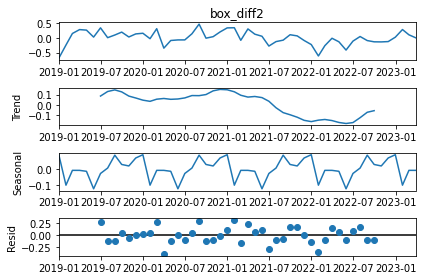

In [123]:
# Regular differentiation
df2_month['box_diff2'] = df2_month.box_diff_seasonal_12 - df2_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(df2_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(df2_month.box_diff2[13:])[1])

plt.show()

In [124]:
df2_month.Close

Date
2017-11-30     379.732093
2017-12-31     640.209291
2018-01-31    1103.646004
2018-02-28     873.116318
2018-03-31     625.761325
                 ...     
2022-11-30    1297.930184
2022-12-31    1237.105890
2023-01-31    1466.950026
2023-02-28    1624.605630
2023-03-31    1625.583903
Freq: M, Name: Close, Length: 65, dtype: float64

## Autocorrelation  <a name="Autocorrelation"></a>

Autocorrelation is the correlation of a time series with the same time series lagged. It summarizes the strength of a relationship with an observation in a time series with observations at prior time steps.

We create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. The idea is to identify presence of AR and MA components in the residuals. 

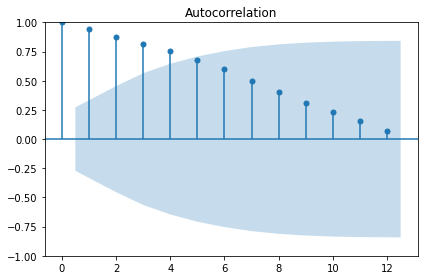

In [125]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df2_month.Close[13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

There is a positive correlation with the first 10 lags that is perhaps significant for the first 2-3 lags.

A good starting point for the AR parameter of the model may be 3.

Lets try out autocorrelation on the differences...

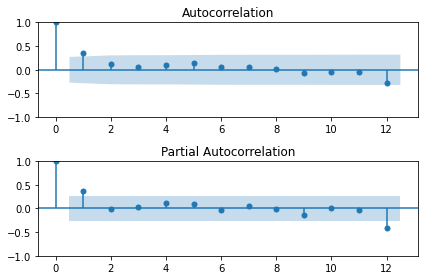

In [126]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
plot_acf(df2_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
plot_pacf(df2_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

There are not many spikes in the plots outside the insignificant zone (shaded) so there may not be enough information available in the residuals to be extracted by AR and MA models. 

# ARIMA Model  <a name="ARIMAModel"/>
AutoRegressive Integrated Moving Average

ARIMA models are denoted with the notation ARIMA(p, d, q). These parameters account for seasonality, trend, and noise in datasets:

     

1.  p - the number of lag observations to include in the model, or lag order.(AR)
2.  d - the number of times that the raw observations are differenced, or the degree of differencing. (I)
3.  q - the size of the moving average window, also called the order of moving average.(MA)


A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.
A value of 0 for a parameter indicates to not use that element of the model. 

## Parameter Selection

We will iteratively explore different combinations of parameters. For each combination we fit a new ARIMA model with SARIMAX() and assess its overall quality.

We will use the AIC (Akaike Information Criterion) value, returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [127]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings
warnings.filterwarnings('ignore')
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = ARIMA(df2_month.close_box, order=(param[0], d, param[1])).fit()
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [128]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters        aic
1     (0, 1) -47.394442
4     (1, 1) -45.760298
2     (0, 2) -45.752932
3     (1, 0) -45.575783
6     (2, 0) -44.449040


## Analysis of Results  <a name="AnalysisARIMA"></a>

The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.


When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

In [129]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])


Dickey–Fuller test:: p=0.000000


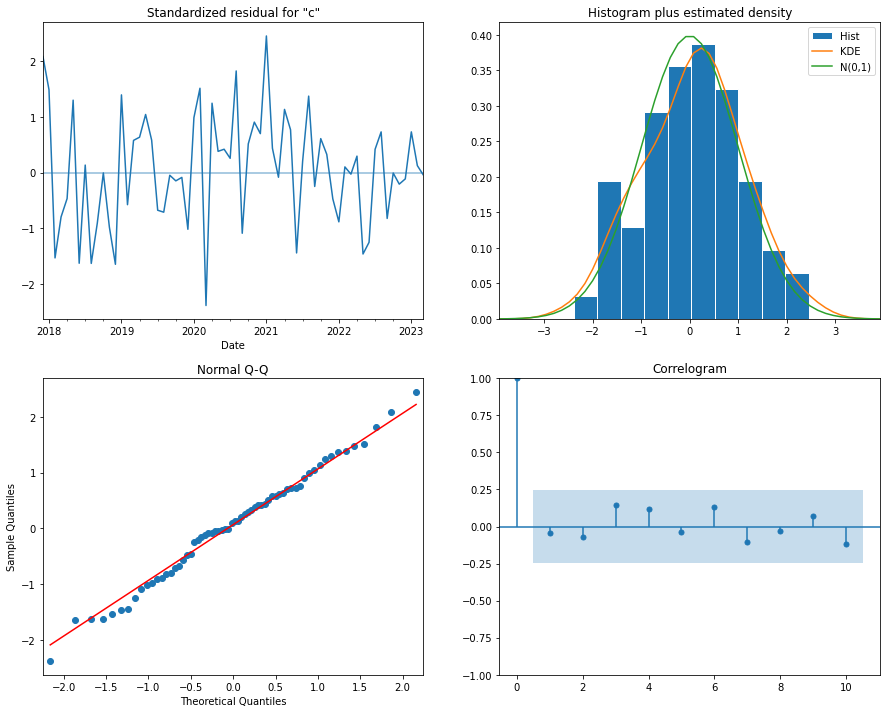

In [130]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [131]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [133]:
df2_month_pred.Close

2017-11-30     379.732093
2017-12-31     640.209291
2018-01-31    1103.646004
2018-02-28     873.116318
2018-03-31     625.761325
                 ...     
2023-03-31    1625.583903
2022-12-31            NaN
2023-01-31            NaN
2023-02-28            NaN
2023-03-31            NaN
Name: Close, Length: 69, dtype: float64

##Prediction


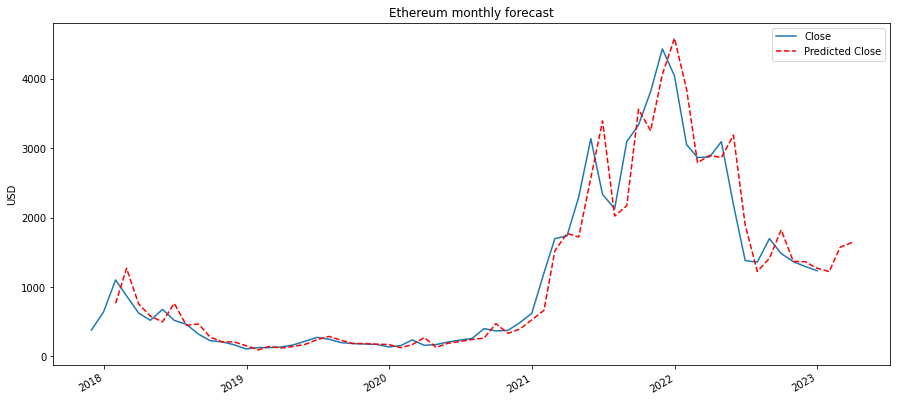

In [132]:
# Prediction
df2_month_pred = df2_month[['Close']]
date_list = [datetime(2022, 12, 31), datetime(2023, 1, 31), datetime(2023, 2, 28), datetime(2023, 3, 31)]
future = pd.DataFrame(index=date_list, columns= df2_month.columns)
df2_month_pred = pd.concat([df2_month_pred, future])

#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
df2_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2018, 1, 31), end=datetime(2023, 3, 31)), lmbda)


plt.figure(figsize=(15,7))
df2_month_pred.Close.plot()
df2_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Ethereum monthly forecast')
plt.ylabel('USD')
plt.show()

## Validation <a name="validationSARIMAX"></a>

A simple indicator of how accurate out forecast is is the root mean square error (RMSE). So lets calcualte RMSE for the one-step ahead predictions starting from 2018, through to the end of 2022.

A simple indicator of how accurate out forecast is is the root mean square error (RMSE). So lets calcualte RMSE for the one-step ahead predictions starting from 2018, through to the end of 2022.

In [134]:
y_forecasted = df2_month_pred.forecast
y_truth = df2_month_pred['2018-1-31':'2022-11-30'].Close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 330.37
